### Module 2 Project - Football Delphi ###
## by Khairul Omar ##

In [890]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import requests
import json

import sqlite3
con = sqlite3.connect('database.sqlite')
cur = con.cursor()

In [1037]:
class WeatherGetter():
    pass

# Please refer to Section 5 below for details of two functions that I have created
# that could have been moved here if I had more time:
#
# getdarksky(lat, lon, date)
# - to fetch All raw data for a given location for ONE Time argument
#
# darksky_rain_info(lat, lon, list_of_dates)
# - to fetch "Weather Icon" info for a given location for a LIST of Time arguments

In [ ]:
class MongoHandler():
    pass

### Data exploration ###

Preview table 1: Unique Teams

In [136]:
# Query table "unique_teams"

query = """SELECT *
           FROM unique_teams
           """
ut = pd.read_sql_query(query, con)
display(ut.shape)
display(ut.head(3))

(128, 2)

,TeamName,Unique_Team_ID
0,Bayern Munich,1
1,Dortmund,2
2,Leverkusen,3


Preview table 2: Team in Matches

In [746]:
# Query table "Team_in_matches"

query = """SELECT *
           FROM Teams_in_matches
           """
tm = pd.read_sql_query(query, con)
display(tm.shape)
display(tm.head(3))

(49148, 2)

,Match_ID,Unique_Team_ID
0,1,26
1,1,46
2,2,26


Preview table 3: Matches

In [1049]:
# Query table "Matches"

query = """SELECT *
           FROM Matches
           WHERE Season == 2011
           ORDER BY HomeTeam, Date
           """
m = pd.read_sql_query(query, con)
display(m.shape)
display(m.head())

(992, 9)

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1574,D2,2011,2011-07-24,Aachen,Braunschweig,0,2,A
1,1507,D2,2011,2011-08-13,Aachen,Cottbus,0,2,A
2,1702,D2,2011,2011-08-27,Aachen,Fortuna Dusseldorf,0,0,D
3,1529,D2,2011,2011-09-18,Aachen,Greuther Furth,0,0,D
4,1662,D2,2011,2011-09-30,Aachen,Frankfurt FSV,1,3,A


In [140]:
# Get high-level total as a reference for checking after joining tables

query = """SELECT SUM(FTHG)+SUM(FTAG) Total_goals
           FROM Matches
           WHERE Season == 2011
           """
m_check = pd.read_sql_query(query, con)
m_check.head()

,Total_goals
0,2796


### Question 1 & 2: The name of the team & the total number of goals scored by team during the 2011 season ###

In [1077]:
# Total goals per team

query = """SELECT Team_name, SUM(Total_goals) Total_goals
           FROM 
                (
                 SELECT ut.TeamName Team_name,
                        SUM(m.FTHG) Total_goals
                 FROM unique_teams ut 
                 JOIN matches m
                 ON ut.TeamName = m.HomeTeam
                 WHERE m.Season == 2011 
                 GROUP BY Team_name 
                 
                 UNION ALL
                 
                 SELECT ut.TeamName Team_name,
                        SUM(m.FTAG) Total_goals
                 FROM unique_teams ut 
                 JOIN matches m
                 ON ut.TeamName = m.AwayTeam
                 WHERE m.Season == 2011
                 GROUP BY Team_name 
                )
           GROUP BY Team_name 
           """    
df1 = pd.read_sql_query(query, con)

display(df1.shape)

# Check total goal matches original source

display(df1.Total_goals.sum())
display(df1.sort_values(by = 'Total_goals', ascending = False).head(10))

(56, 2)

2796

,Team_name,Total_goals
35,Man City,93
36,Man United,89
11,Dortmund,80
4,Bayern Munich,77
14,Ein Frankfurt,76
1,Arsenal,74
43,Schalke 04,74
22,Greuther Furth,73
49,Tottenham,66
9,Chelsea,65


### Question 3: The total number of wins the team earned during the 2011 season ###

In [1028]:
# Number of Wins

query = """ SELECT * FROM
                         (
                          SELECT CASE
                                      WHEN FTHG > FTAG THEN HomeTeam
                                      WHEN FTHG < FTAG THEN AwayTeam
                                      ELSE "Draw"
                                      END Team_name,
                                 COUNT(Match_ID) Num_of_wins
                          FROM Matches
                          WHERE Season == 2011
                          GROUP BY Team_name
                         )
                      WHERE Team_name != "Draw"
                      """
df3 = pd.read_sql_query(query, con)
display(df3.shape)
display(df3.sort_values(by = 'Num_of_wins', ascending = False).head(10))

(56, 2)

,Team_name,Num_of_wins
36,Man United,28
35,Man City,28
11,Dortmund,25
4,Bayern Munich,23
1,Arsenal,21
49,Tottenham,20
43,Schalke 04,20
14,Ein Frankfurt,20
22,Greuther Furth,20
38,Newcastle,19


**Question 4: A histogram visualization of the team's wins and losses for the 2011 season (store the visualization directly by assigning it to a variable)**

In [1015]:
# Number of Wins & Losses by team combined

query = """SELECT * FROM
                         (
                          SELECT t1.Team_name, t1.Num_of_wins, t2.Num_of_loss
                          FROM
                               (
                                SELECT CASE
                                            WHEN FTHG > FTAG THEN HomeTeam
                                            WHEN FTHG < FTAG THEN AwayTeam
                                            ELSE "Draw"
                                            END Team_name,
                                       COUNT(Match_ID) Num_of_wins
                                FROM Matches
                                WHERE Season == 2011
                                GROUP BY Team_name
                               )
                                t1
                          JOIN
                               (
                                SELECT CASE
                                            WHEN FTHG < FTAG THEN HomeTeam
                                            WHEN FTHG > FTAG THEN AwayTeam
                                            ELSE "Draw"
                                            END Team_name,
                                       COUNT(Match_ID) Num_of_loss
                                FROM Matches
                                WHERE Season == 2011
                                GROUP BY Team_name
                               )
                                t2
                          ON t1.Team_name = t2.Team_name
                         )
                     WHERE Team_name != "Draw"
                     """
df4 = pd.read_sql_query(query, con)
display(df4.shape)
df4_sort = df4.sort_values(by = 'Num_of_wins', ascending = False)
display(df4_sort.head(10))

(56, 3)

,Team_name,Num_of_wins,Num_of_loss
36,Man United,28,5
35,Man City,28,5
11,Dortmund,25,3
4,Bayern Munich,23,7
1,Arsenal,21,10
49,Tottenham,20,9
43,Schalke 04,20,10
14,Ein Frankfurt,20,6
22,Greuther Furth,20,4
38,Newcastle,19,11


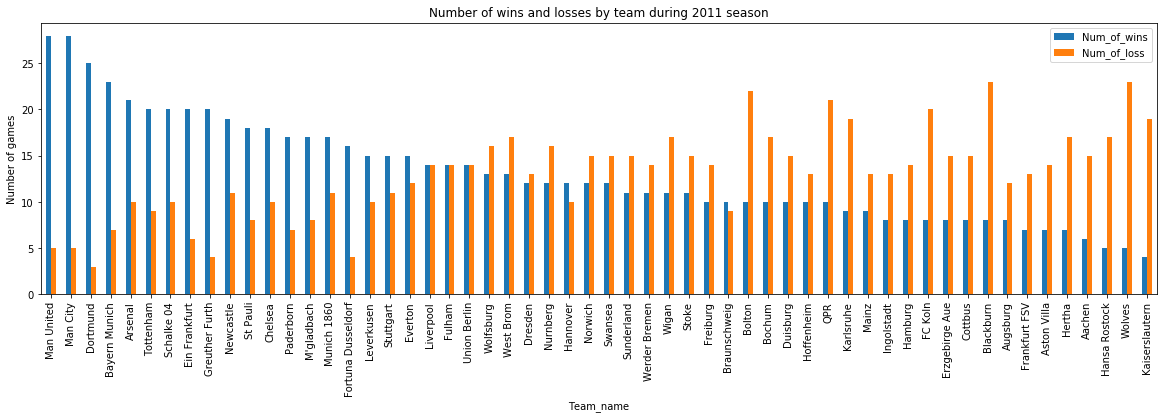

In [1016]:
# Plot data above

fig = plt.figure(figsize=(20,5))
ax  = plt.subplot()
fig.add_axes(ax)

ax.set_title('Number of wins and losses by team during 2011 season')
ax.set_ylabel('Number of games')
df4_sort.plot(x="Team_name", kind="bar", ax=ax)

### Question 5: The team's win percentage on days where it was raining during games in the 2011 season. ###

**Part 1: Explore and extract from DarkSky API:**

In [840]:
# Define functions to fetch data:

def get_keys(path):
    with open(path) as f:
        return json.load(f)
keys = get_keys("../darksky.json")
api_key = keys['api_key']

In [841]:
# Function to fetch data from Dark Sky

def getdarksky(lat,lon,time):
    link = f'https://api.darksky.net/forecast/{api_key}/{lat},{lon},{time}'
    r = requests.get(link)
    return r.json()

In [1017]:
# Using Berlin coordinates as assumption for all locations

# Preview sample data from today

lat = 52.5200
lon = -13.4050
timeRecent = '2019-10-10T00:00:00Z'

sky = getdarksky(lat, lon, timeRecent)

In [843]:
# Explore json output's high-level structure

sky.keys()

dict_keys(['latitude', 'longitude', 'timezone', 'currently', 'hourly', 'daily', 'flags', 'offset'])

In [1021]:
len(sky.keys())

8

In [1031]:
# Explore json output's structure for Current weather (at requested time)

sky['currently'].keys()

dict_keys(['time', 'summary', 'icon', 'precipIntensity', 'precipProbability', 'precipType', 'temperature', 'apparentTemperature', 'dewPoint', 'humidity', 'pressure', 'windSpeed', 'windGust', 'windBearing', 'cloudCover', 'uvIndex', 'visibility', 'ozone'])

In [1018]:
# Identify useful key(s) that can be useful to determine weather status

sky['currently']

{'time': 1570665600,
 'summary': 'Mostly Cloudy',
 'icon': 'partly-cloudy-night',
 'precipIntensity': 0.0004,
 'precipProbability': 0.07,
 'precipType': 'rain',
 'temperature': 54.82,
 'apparentTemperature': 54.82,
 'dewPoint': 46.02,
 'humidity': 0.72,
 'pressure': 1009.3,
 'windSpeed': 22.19,
 'windGust': 25.99,
 'windBearing': 250,
 'cloudCover': 0.66,
 'uvIndex': 0,
 'visibility': 10,
 'ozone': 269.7}

In [1020]:
# Select this key as a marker if it rained on a given day

weather_type = sky['currently']['icon']
weather_type

'partly-cloudy-night'

In [847]:
# Get dates of all matches from SQL

query = """SELECT DISTINCT Date
           FROM Matches
           WHERE Season == 2011
           ORDER BY Date
           """
matchdates = pd.read_sql_query(query, con)
display(matchdates.shape)
display(matchdates.dtypes)


(165, 1)

Date    object
dtype: object

In [1032]:
# Convert date to the input format required by DarkSky

matchdates['Darksky_date'] = matchdates['Date'].map(lambda x: f'{x}T00:00:00Z')
display(matchdates.head(5))

,Date,Darksky_date
0,2011-07-15,2011-07-15T00:00:00Z
1,2011-07-16,2011-07-16T00:00:00Z
2,2011-07-17,2011-07-17T00:00:00Z
3,2011-07-18,2011-07-18T00:00:00Z
4,2011-07-22,2011-07-22T00:00:00Z


In [849]:
# Limit number of dates first for testing

testdates = list(matchdates.Darksky_date[0:10])
berlin_lat = 52.5200
berlin_lon = -13.4050

In [1043]:
# Function to extract rain information from multiple dates

def darksky_rain_info(lat, lon, list_of_dates):
    
    precipTypeList = []
    
    for date in list_of_dates:
        link = f'https://api.darksky.net/forecast/{api_key}/{lat},{lon},{date}'
        r = requests.get(link)
        skydata = r.json()
        if len(skydata) >= 8:
            precipType = skydata['currently']['icon']
        else:
            precipType = f'No data. Status={r.status_code}'
        precipTypeList.append(precipType)
        
    precipTypeInfo = {}
    
    for i in range(len(list_of_dates)):
        precipTypeInfo[list_of_dates[i]] = precipTypeList[i]    
            
    return precipTypeInfo


In [1044]:
# Run rain info with test data

darksky_rain_info(berlin_lat, berlin_lon, testdates)


{'2011-07-15T00:00:00Z': 'No data. Status=200',
 '2011-07-16T00:00:00Z': 'No data. Status=200',
 '2011-07-17T00:00:00Z': 'No data. Status=200',
 '2011-07-18T00:00:00Z': 'No data. Status=200',
 '2011-07-22T00:00:00Z': 'No data. Status=200',
 '2011-07-23T00:00:00Z': 'No data. Status=200',
 '2011-07-24T00:00:00Z': 'No data. Status=200',
 '2011-07-25T00:00:00Z': 'No data. Status=200',
 '2011-08-05T00:00:00Z': 'No data. Status=200',
 '2011-08-06T00:00:00Z': 'No data. Status=200'}

**Note:**<br>
For some unexplained reason, DarkSky data is not available to me when the dates are **older than the past 1 year**. Data older than 12-12-2018 gives out a valid status but the json output has no data inside it. <br><br>
To confirm that this is an API issue instead of my Python codes, I tested this directly on the browser to bypass any coding and still get the same the result. Here's a sample when I entered 2011 data (as per the league table dates):

In [1022]:
# Preview sample data from 2011 - Note that the generated data is practically blank.
# I got the same missing data even when keyed in directly into the browser at:
# https://api.darksky.net/forecast/e03e59714456ab18516c672f47df1166/52.52,-13.405,2011-07-15T00:00:00

time2011 = '2011-07-15T00:00:00Z'

sky2011 = getdarksky(berlin_lat, berlin_lon, time2011)
sky2011['currently']

{'time': 1310688000, 'uvIndex': 0}

Now to demonstrate that there is no data if I go back to dates **older than 1 year ago** before 13-12-2018.<br>
All dates after 13-12-2018 have no issues.

In [1081]:
# Using 9 dates between 2018-12-08 and 2018-12-16 to demonstrate this:

testdates2 = ['2018-12-08T00:00:00Z', '2018-12-09T00:00:00Z', '2018-12-10T00:00:00Z',
              '2018-12-11T00:00:00Z', '2018-12-12T00:00:00Z', '2018-12-13T00:00:00Z',
              '2018-12-14T00:00:00Z', '2018-12-15T00:00:00Z', '2018-12-16T00:00:00Z']

darkskytest2018 = darksky_rain_info(berlin_lat, berlin_lon, testdates2)
darkskytest2018

{'2018-12-08T00:00:00Z': 'No data. Status=200',
 '2018-12-09T00:00:00Z': 'No data. Status=200',
 '2018-12-10T00:00:00Z': 'No data. Status=200',
 '2018-12-11T00:00:00Z': 'No data. Status=200',
 '2018-12-12T00:00:00Z': 'No data. Status=200',
 '2018-12-13T00:00:00Z': 'partly-cloudy-night',
 '2018-12-14T00:00:00Z': 'partly-cloudy-night',
 '2018-12-15T00:00:00Z': 'partly-cloudy-night',
 '2018-12-16T00:00:00Z': 'wind'}

For the purpose of this exercise, since the API only gives me data for the past 1 year, I'm going to **restate 2011/2012 to be 2019** where API data is available:
<br><br>

In [1023]:
# Restating 2011/2012 dates into 2019 dates so that we can move on:
# input in yyyy-mm-dd (with dash)

def convert2019date(yyyymmdd):
    
    date_year  = yyyymmdd[0:4]
    date_month = yyyymmdd[5:7]
    date_day   = yyyymmdd[8:11]

    new_year   = 2019 
    
    temp_month = int(yyyymmdd[5:7]) - 6 if int(yyyymmdd[5:7]) > 6 else int(yyyymmdd[5:7]) + 6

    new_month  = '0' + str(temp_month) if temp_month < 10 else temp_month

    return f'{new_year}-{new_month}-{date_day}T00:00:00Z'

matchdates['Darksky_date'] = matchdates['Date'].map(convert2019date)

matchdates.head()

,Date,Darksky_date
0,2011-07-15,2019-01-15T00:00:00Z
1,2011-07-16,2019-01-16T00:00:00Z
2,2011-07-17,2019-01-17T00:00:00Z
3,2011-07-18,2019-01-18T00:00:00Z
4,2011-07-22,2019-01-22T00:00:00Z


In [860]:
# Now test if API data is available for the restated dates:

testdates2019 = list(matchdates.Darksky_date[0:5])

darkskytest2019 = darksky_rain_info(berlin_lat, berlin_lon, testdates2019)
darkskytest2019

{'2019-01-15T00:00:00Z': 'cloudy',
 '2019-01-16T00:00:00Z': 'cloudy',
 '2019-01-17T00:00:00Z': 'partly-cloudy-night',
 '2019-01-18T00:00:00Z': 'wind',
 '2019-01-22T00:00:00Z': 'wind'}

In [1007]:
# Fetch DarkSky with all dates

searchdates = list(matchdates.Darksky_date)

berlin_rain_dict = darksky_rain_info(berlin_lat, berlin_lon, searchdates)

In [1034]:
# Quick test on output

display(berlin_rain_dict['2019-01-16T00:00:00Z'])
display(berlin_rain_dict['2019-01-17T00:00:00Z'])

'cloudy'

'partly-cloudy-night'

In [1006]:
# Move to data frame and explore full weather data

rain_df = pd.DataFrame(list(berlin_rain_dict.values()), index=list(berlin_rain_dict.keys()))
rain_df = rain_df.rename(columns={0 : "Weather"})
rain_df.iloc[11:18]

,Weather
2019-02-08T00:00:00Z,rain
2019-02-12T00:00:00Z,wind
2019-02-13T00:00:00Z,wind
2019-02-14T00:00:00Z,cloudy
2019-02-15T00:00:00Z,wind
2019-02-19T00:00:00Z,cloudy
2019-02-20T00:00:00Z,rain


**Part 2: Analyze team performance based on weather conditions:**

In [1030]:
# Return to SQL table Match

query = """SELECT *
           FROM Matches
           WHERE Season == 2011
           ORDER BY HomeTeam, Date
           """
df = pd.read_sql_query(query, con)
display(df.shape)

# Include WEATHER information to Match table

df['Darksky_date'] = df['Date'].map(convert2019date)
df = df.set_index('Darksky_date')
df = df.join(rain_df)
df = df.reset_index()
df = df.drop(columns='index')

display(df.shape)

display(df.iloc[10:20])

(992, 9)

(992, 10)

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Weather
10,1505,D2,2011,2011-07-22,Duisburg,Cottbus,1,2,A,wind
11,1596,D2,2011,2011-07-22,Ingolstadt,Erzgebirge Aue,0,0,D,wind
12,1261,D2,2011,2011-07-23,Munich 1860,Karlsruhe,2,1,H,cloudy
13,1525,D2,2011,2011-07-23,Union Berlin,Greuther Furth,0,4,A,cloudy
14,1574,D2,2011,2011-07-24,Aachen,Braunschweig,0,2,A,wind
15,1390,D2,2011,2011-07-24,Dresden,Hansa Rostock,1,1,D,wind
16,1699,D2,2011,2011-07-24,Paderborn,Fortuna Dusseldorf,1,1,D,wind
17,1463,D2,2011,2011-07-25,Ein Frankfurt,St Pauli,1,1,D,partly-cloudy-night
18,1219,D1,2011,2011-08-05,Dortmund,Hamburg,3,1,H,rain
19,1684,D2,2011,2011-08-05,Fortuna Dusseldorf,Ingolstadt,4,1,H,rain


In [931]:
# Explore types of weather and its frequency by num of match days

df_chk1 = df.drop_duplicates(['Date','Weather'])[['Date','Weather']]
df_chk1.Weather.value_counts()

partly-cloudy-night    58
wind                   42
cloudy                 31
rain                   15
clear-night            15
No data. Status=400     4
Name: Weather, dtype: int64

In [962]:
# Filter to get rainy days only and exclude draws

df_rain = df.loc[(df['Weather'] == 'rain') & (df['FTR'] != 'D'),
                ['HomeTeam', 'AwayTeam', 'FTR', 'Weather']]

# Pick winners only

df_rain['Win_rain'] = df_rain.apply(lambda row: row['HomeTeam'] if row['FTR'] == 'H' else row['AwayTeam'], axis=1)

# Count number of times winner appears (on rainy days)

df_rain_win = pd.DataFrame(df_rain.Win_rain.value_counts())
df_rain_win.head()

,Win_rain
Dortmund,4
Arsenal,4
Bayern Munich,4
Union Berlin,3
Greuther Furth,3


In [963]:
# Back to the previous wins & losses table from Question 4

df4.head()

,Team_name,Num_of_wins,Num_of_loss
0,Aachen,6,15
1,Arsenal,21,10
2,Aston Villa,7,14
3,Augsburg,8,12
4,Bayern Munich,23,7


In [1025]:
# Join Win statistics with Weather information

df5 = df4
df5 = df5.set_index('Team_name')
df5 = df4.join(df_rain_win, on = 'Team_name')
df5['Win_rain'] = df5['Win_rain'].fillna(0)
df5['Win_rain'] = df5['Win_rain'].astype(int)
df5 = df5.drop(columns = ['Num_of_loss'])
df5

# Calculate the % winning games per team when it rains

df5['Rain_win_rate'] = df5['Win_rain'] / df5['Num_of_wins']
df5_sort = df5.sort_values(by = 'Rain_win_rate', ascending = False)

df5_sort.head(10)

# Note that the percentages below will be different from other students
# since I am using Jan-Dec 2019 data as an assumption


,Team_name,Num_of_wins,Win_rain,Rain_win_rate
27,Hoffenheim,10,3,0.300000
26,Hertha,7,2,0.285714
51,Werder Bremen,11,3,0.272727
29,Kaiserslautern,4,1,0.250000
12,Dresden,12,3,0.250000
50,Union Berlin,14,3,0.214286
55,Wolves,5,1,0.200000
25,Hansa Rostock,5,1,0.200000
1,Arsenal,21,4,0.190476
18,Fortuna Dusseldorf,16,3,0.187500


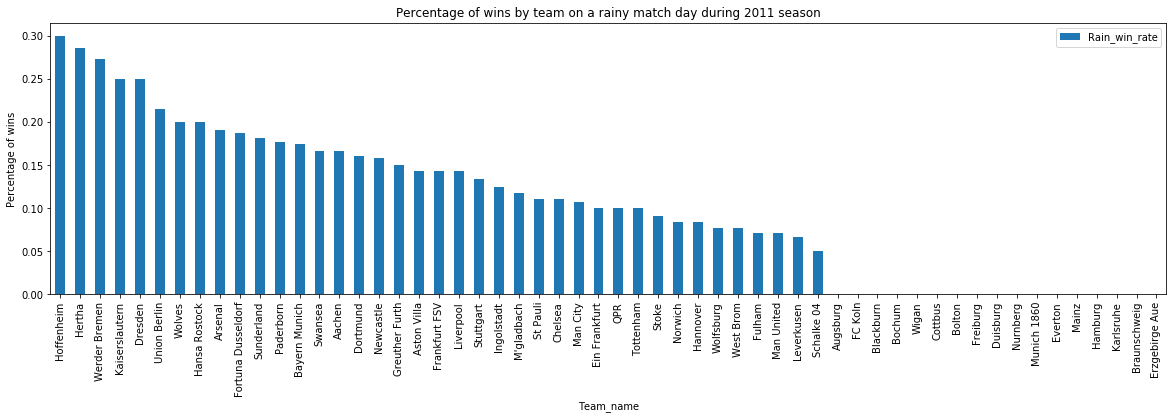

In [1002]:
fig = plt.figure(figsize=(20,5))
ax  = plt.subplot()
fig.add_axes(ax)

ax.set_title('Percentage of wins by team on a rainy match day during 2011 season')
ax.set_ylabel('Percentage of wins')
df5_sort.plot(x="Team_name", y="Rain_win_rate", kind="bar", ax=ax)

# Summary

In this lab, we dug deep and used everything we've learned so far about python programming, databases, HTTP requests and API calls to ETL data from a SQL database into a MongoDB instance!